### Treatment: 
* MO (population: 6.2) - Stay at Home Order (April 6, 2020)

### Control (Stay-At-Home Order Announced After 4/6/2020): 
* NE (population: 2.0) - Never issued

* IA (population: 3.2) - Never issued

* AR (population: 3.0) - Never issued

Population Reference (Population data are based on resident population of the U.S. in 2020, by state (in millions))
* https://www.statista.com/statistics/183497/population-in-the-federal-states-of-the-us/

Stay-At-Home Order References
* https://www.usatoday.com/storytelling/coronavirus-reopening-america-map/

In [1]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import datetime
import os
import sys
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
# load data for covid cases
daily_cases = pd.read_csv("./data/us-counties-covid-cases.csv")
# treatment - MO
daily_cases_MO = daily_cases[daily_cases["state"] == "Missouri"]
# control - NE, IA, AR
daily_cases_NE = daily_cases[daily_cases["state"] == "Nebraska"]
daily_cases_IA = daily_cases[daily_cases["state"] == "Iowa"]
daily_cases_AR = daily_cases[daily_cases["state"] == "Arkansas"]

<IPython.core.display.Javascript object>

In [3]:
daily_cases_MO.sample(5)

,date,county,state,fips,cases,deaths
967381,2021-01-26,Camden,Missouri,29029.0,3575,73.0
131753,2020-05-10,Washington,Missouri,29221.0,9,1.0
119800,2020-05-06,Ray,Missouri,29177.0,11,0.0
850625,2020-12-21,Putnam,Missouri,29171.0,190,1.0
733755,2020-11-15,Lewis,Missouri,29111.0,359,2.0


<IPython.core.display.Javascript object>

In [4]:
# load population data
pop =  pd.read_excel("./co-est2019-annres.xlsx",  header=[0,1,2,3])
pop.columns = pop.columns.droplevel([0,1,2])
pop.rename(columns={"Unnamed: 0_level_3": "Geographic Area"}, inplace = True)
pop["Geographic Area"] = pop["Geographic Area"].str.replace('.','', regex=True)

<IPython.core.display.Javascript object>

In [5]:
# subset population data to MO
pop_MO = pop[pop['Geographic Area'].str.endswith("Missouri")]
# use 2019 population
pop_MO = pop_MO.iloc[:, [0] + [-1]]
# rename county column
pop_MO['Geographic Area'] = pop_MO['Geographic Area'].str.replace(' County, Missouri', '')
pop_MO['Geographic Area'] = pop_MO['Geographic Area'].str.replace(', Missouri', '')
# rename county in daily cases dataframe to ensure naming consistency
daily_cases_MO['county'] = daily_cases_MO['county'].str.replace('.', '')
# drop counties where there is no population data
daily_cases_MO = daily_cases_MO[(daily_cases_MO['county'] != 'Joplin') & (daily_cases_MO['county'] != 'Kansas City')]
# rename dataframe columnes 
pop_MO.columns = ['County', 'population']

# subset population data to NE
pop_NE = pop[pop['Geographic Area'].str.endswith(", Nebraska")]
pop_NE = pop_NE.iloc[:-1]
# use 2019 population
pop_NE = pop_NE.iloc[:, [0] + [-1]]
# rename county column
pop_NE['Geographic Area'] = pop_NE['Geographic Area'].str.replace(' County, Nebraska', '')
# drop counties where there is no population data
daily_cases_NE = daily_cases_NE[daily_cases_NE['county'] != 'York']
# rename dataframe columnes 
pop_NE.columns = ['County', 'population']

# subset population data to IA
pop_IA = pop[pop['Geographic Area'].str.endswith("Iowa")]
# use 2019 population
pop_IA = pop_IA.iloc[:, [0] + [-1]]
# rename county column
pop_IA['Geographic Area'] = pop_IA['Geographic Area'].str.replace(' County, Iowa', '')
# rename dataframe columnes 
pop_IA.columns = ['County', 'population']

# subset population data to AR
pop_AR = pop[pop['Geographic Area'].str.endswith("Arkansas")]
# use 2019 population
pop_AR = pop_AR.iloc[:, [0] + [-1]]
# rename county column
pop_AR['Geographic Area'] = pop_AR['Geographic Area'].str.replace(' County, Arkansas', '')
# rename county in daily cases dataframe to ensure naming consistency
daily_cases_AR['county'] = daily_cases_AR['county'].str.replace('.', '')
# rename dataframe columnes 
pop_AR.columns = ['County', 'population']

<IPython.core.display.Javascript object>

In [6]:
# remove uknown counties
daily_cases_MO = daily_cases_MO[daily_cases_MO['county']!='Unknown']
daily_cases_NE = daily_cases_NE[daily_cases_NE['county']!='Unknown']
daily_cases_IA = daily_cases_IA[daily_cases_IA['county']!='Unknown']
daily_cases_AR = daily_cases_AR[daily_cases_AR['county']!='Unknown']

<IPython.core.display.Javascript object>

In [7]:
# make sure counties are matching in COVID cases & population datasets
sorted(pop_MO.County.unique()) == sorted(daily_cases_MO.county.unique())

True

<IPython.core.display.Javascript object>

In [8]:
sorted(pop_NE.County.unique()) == sorted(daily_cases_NE.county.unique())

True

<IPython.core.display.Javascript object>

In [9]:
sorted(pop_IA.County.unique()) == sorted(daily_cases_IA.county.unique())

True

<IPython.core.display.Javascript object>

In [10]:
sorted(pop_AR.County.unique()) == sorted(daily_cases_AR.county.unique())

True

<IPython.core.display.Javascript object>

In [11]:
# set comparison period to be 21 days
numdays = 21

<IPython.core.display.Javascript object>

In [12]:
# retrieve policy date for MO Stay at Home Order
policy_mo = datetime.datetime.strptime('06042020', "%d%m%Y").date()
date_before_mo = [policy_mo - datetime.timedelta(days=x) for x in range(numdays+1)]
date_after_mo = [policy_mo + datetime.timedelta(days=x) for x in range(numdays+1)]
date_list_mo = date_before_mo + date_after_mo

# data cleaning - treatment state: MO
daily_mo = daily_cases_MO.copy()
daily_mo["date"] = pd.to_datetime(daily_mo["date"])
daily_mo_timed = daily_mo.loc[daily_mo["date"].isin(date_list_mo)] # covering a total of 43 days (21 + 21 + 1)

# merge MO population with COVID cases
merged_MO = pd.merge(left=daily_mo_timed, right=pop_MO, how='left', left_on='county', right_on='County')

# drop duplicated MO County column
merged_MO = merged_MO.drop('County', axis=1)
# create MO standardized COVID cases column
merged_MO['cases_standardized'] = merged_MO['cases']/merged_MO['population']*10000

# create indicator variable - pre and post policy annoucement
merged_MO['post_policy'] = (merged_MO.date > '2020-04-06')
merged_MO.sample(5)

,date,county,state,fips,cases,deaths,population,cases_standardized,post_policy
270,2020-03-28,Cape Girardeau,Missouri,29031.0,6,0.0,78871.0,0.760736,False
1164,2020-04-09,Platte,Missouri,29165.0,21,0.0,104418.0,2.011148,True
2820,2020-04-27,Lewis,Missouri,29111.0,6,1.0,9776.0,6.137480,True
960,2020-04-07,DeKalb,Missouri,29063.0,1,0.0,12547.0,0.797003,True
2555,2020-04-24,Pulaski,Missouri,29169.0,33,1.0,52607.0,6.272929,True


<IPython.core.display.Javascript object>

In [13]:
# data cleaning - control state: NE
daily_ne = daily_cases_NE.copy()
daily_ne["date"] = pd.to_datetime(daily_ne["date"])
daily_ne_timed = daily_ne.loc[daily_ne["date"].isin(date_list_mo)]

# merge NE population with COVID cases
merged_NE = pd.merge(left=daily_ne_timed, right=pop_NE, how='left', left_on='county', right_on='County')

# drop duplicated NE County column
merged_NE = merged_NE.drop('County', axis=1)
# create NE standardized COVID cases column
merged_NE['cases_standardized'] = merged_NE['cases']/merged_NE['population']*10000

# create indicator variable - pre and post policy annoucement
merged_NE['post_policy'] = (merged_NE.date > '2020-04-06')
merged_NE.sample(5)

,date,county,state,fips,cases,deaths,population,cases_standardized,post_policy
740,2020-04-16,Franklin,Nebraska,31061.0,3,0.0,2979.0,10.070493,True
695,2020-04-15,Franklin,Nebraska,31061.0,3,0.0,2979.0,10.070493,True
698,2020-04-15,Hall,Nebraska,31079.0,278,5.0,61353.0,45.311558,True
456,2020-04-09,Merrick,Nebraska,31121.0,2,0.0,7755.0,2.578981,True
178,2020-03-31,Cass,Nebraska,31025.0,2,0.0,26248.0,0.761963,False


<IPython.core.display.Javascript object>

In [14]:
# data cleaning - control state: IA
daily_ia = daily_cases_IA.copy()
daily_ia["date"] = pd.to_datetime(daily_ia["date"])
daily_ia_timed = daily_ia.loc[daily_ia["date"].isin(date_list_mo)] 

# merge IA population with COVID cases
merged_IA = pd.merge(left=daily_ia_timed, right=pop_IA, how='left', left_on='county', right_on='County')

# drop duplicated IA County column
merged_IA = merged_IA.drop('County', axis=1)
# create IA standardized COVID cases column
merged_IA['cases_standardized'] = merged_IA['cases']/merged_IA['population']*10000

# create indicator variable - pre and post policy annoucement
merged_IA['post_policy'] = (merged_IA.date > '2020-04-06')
merged_IA.sample(5)

,date,county,state,fips,cases,deaths,population,cases_standardized,post_policy
2000,2020-04-20,Tama,Iowa,19171.0,198,6.0,16854.0,117.479530,True
2221,2020-04-23,Jackson,Iowa,19097.0,5,0.0,19439.0,2.572149,True
1117,2020-04-10,Audubon,Iowa,19009.0,1,0.0,5496.0,1.819505,True
958,2020-04-08,Appanoose,Iowa,19007.0,1,1.0,12426.0,0.804764,True
1176,2020-04-10,Pottawattamie,Iowa,19155.0,12,0.0,93206.0,1.287471,True


<IPython.core.display.Javascript object>

In [15]:
# data cleaning - control state: AR
daily_ar = daily_cases_AR.copy()
daily_ar["date"] = pd.to_datetime(daily_ar["date"])
daily_ar_timed = daily_ar.loc[daily_ar["date"].isin(date_list_mo)]

# merge AR population with COVID cases
merged_AR = pd.merge(left=daily_ar_timed, right=pop_AR, how='left', left_on='county', right_on='County')

# drop duplicated AR County column
merged_AR = merged_AR.drop('County', axis=1)
# create AR standardized COVID cases column
merged_AR['cases_standardized'] = merged_AR['cases']/merged_AR['population']*10000

# create indicator variable - pre and post policy annoucement
merged_AR['post_policy'] = (merged_AR.date > '2020-04-06')
merged_AR.sample(5)

,date,county,state,fips,cases,deaths,population,cases_standardized,post_policy
1169,2020-04-11,Cleburne,Arkansas,5023.0,69,4.0,24919.0,27.689715,True
1722,2020-04-18,White,Arkansas,5145.0,29,0.0,78753.0,3.682399,True
514,2020-04-01,Arkansas,Arkansas,5001.0,2,0.0,17486.0,1.143772,False
1167,2020-04-11,Clark,Arkansas,5019.0,27,0.0,22320.0,12.096774,True
1993,2020-04-22,Pulaski,Arkansas,5119.0,414,12.0,391911.0,10.563623,True


<IPython.core.display.Javascript object>

In [16]:
# stack 3 control states
merged_control = merged_NE.append([merged_IA, merged_AR])
merged_control.sample(5)

,date,county,state,fips,cases,deaths,population,cases_standardized,post_policy
36,2020-03-19,Polk,Iowa,19153.0,6,0.0,490161.0,0.122409,False
1959,2020-04-20,Greene,Iowa,19073.0,1,0.0,8888.0,1.125113,True
206,2020-03-25,Desha,Arkansas,5041.0,2,0.0,11361.0,1.760408,False
1240,2020-04-12,Cleveland,Arkansas,5025.0,8,0.0,7956.0,10.055304,True
43,2020-03-19,Poinsett,Arkansas,5111.0,1,0.0,23528.0,0.425026,False


<IPython.core.display.Javascript object>

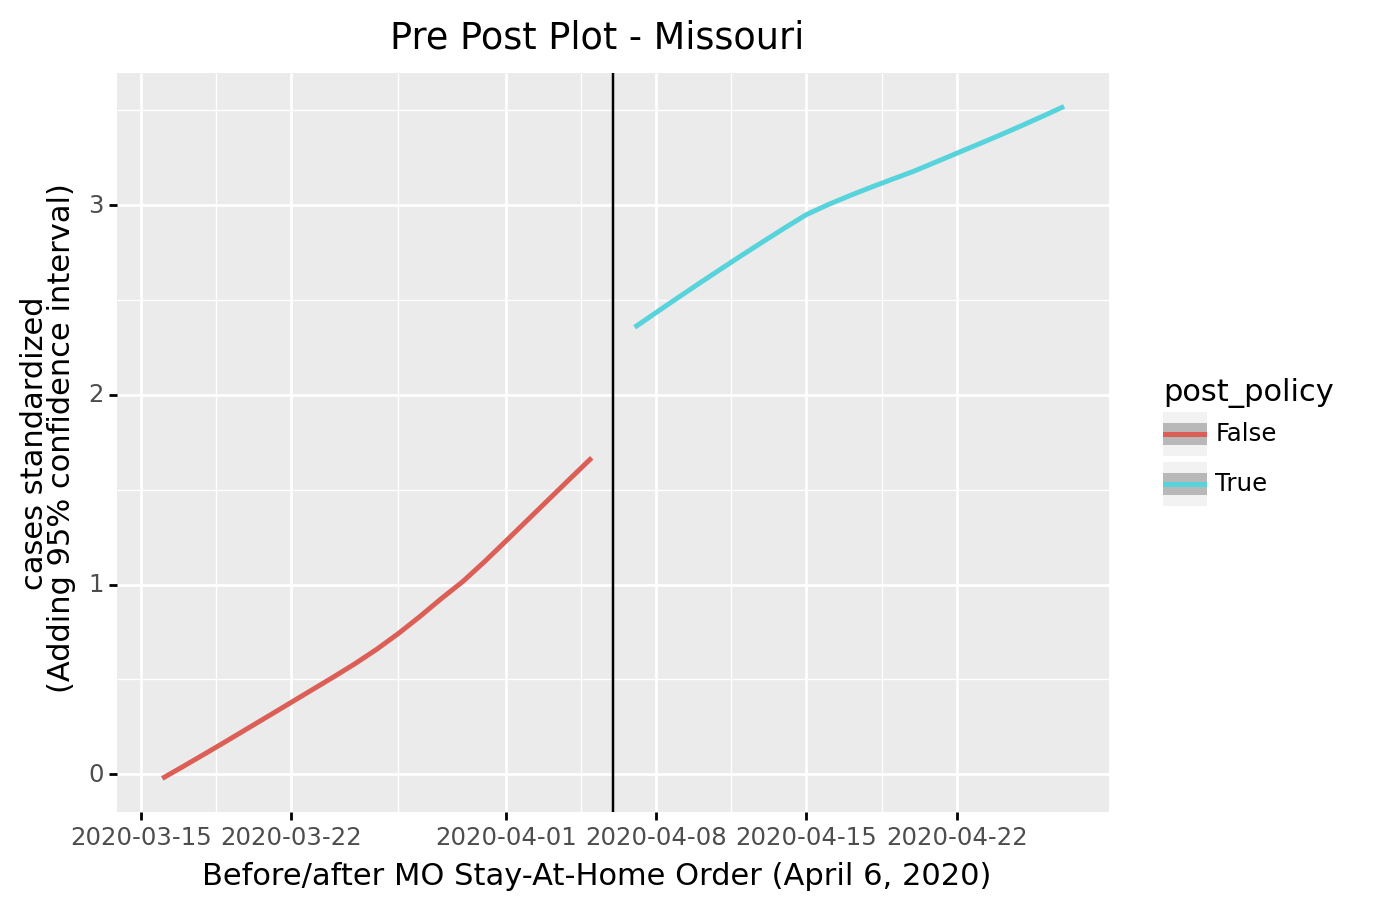

<ggplot: (8761808423909)>

<IPython.core.display.Javascript object>

In [17]:
# pre-post plot - MO
(ggplot() +
    geom_smooth(merged_MO[merged_MO['date'] < '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess') + 
    geom_smooth(merged_MO[merged_MO['date'] > '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess')
    + xlab('Before/after MO Stay-At-Home Order (April 6, 2020)') 
    + ylab(str("cases standardized") + ' \n(Adding 95% confidence interval)')
    + geom_vline(xintercept = '2020-04-06')
    + labs(title=str("Pre Post Plot - Missouri")))

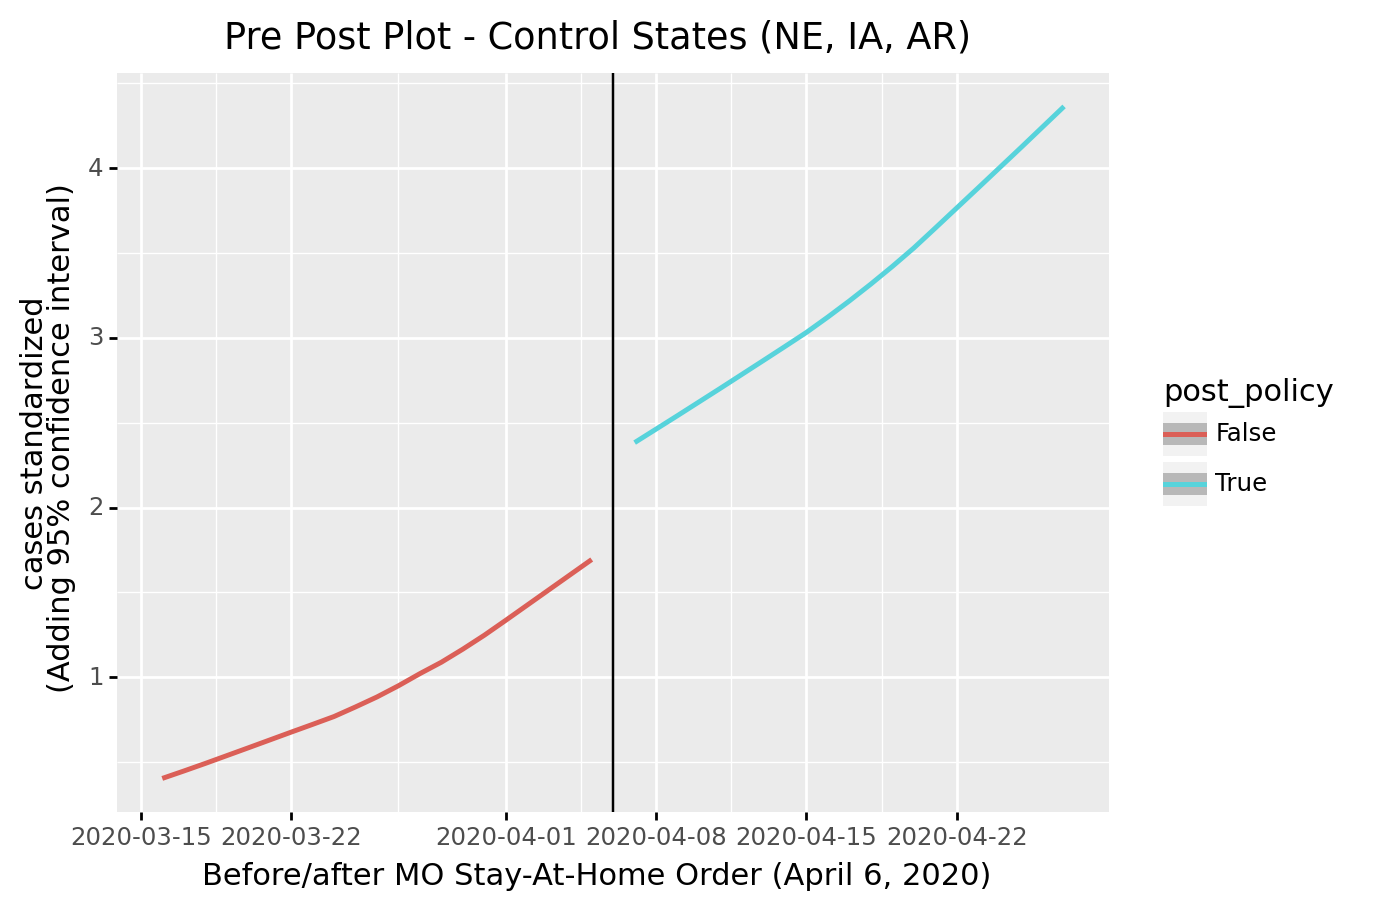

<ggplot: (8761808907770)>

<IPython.core.display.Javascript object>

In [18]:
# pre-post plot - control States (NE, IA, AR)
(ggplot() +
    geom_smooth(merged_control[merged_control['date'] < '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess') + 
    geom_smooth(merged_control[merged_control['date'] > '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='post_policy'), method='lowess')
    + xlab('Before/after MO Stay-At-Home Order (April 6, 2020)') 
    + ylab(str("cases standardized") + ' \n(Adding 95% confidence interval)')
    + geom_vline(xintercept = '2020-04-06')
    + labs(title=str("Pre Post Plot - Control States (NE, IA, AR)")))

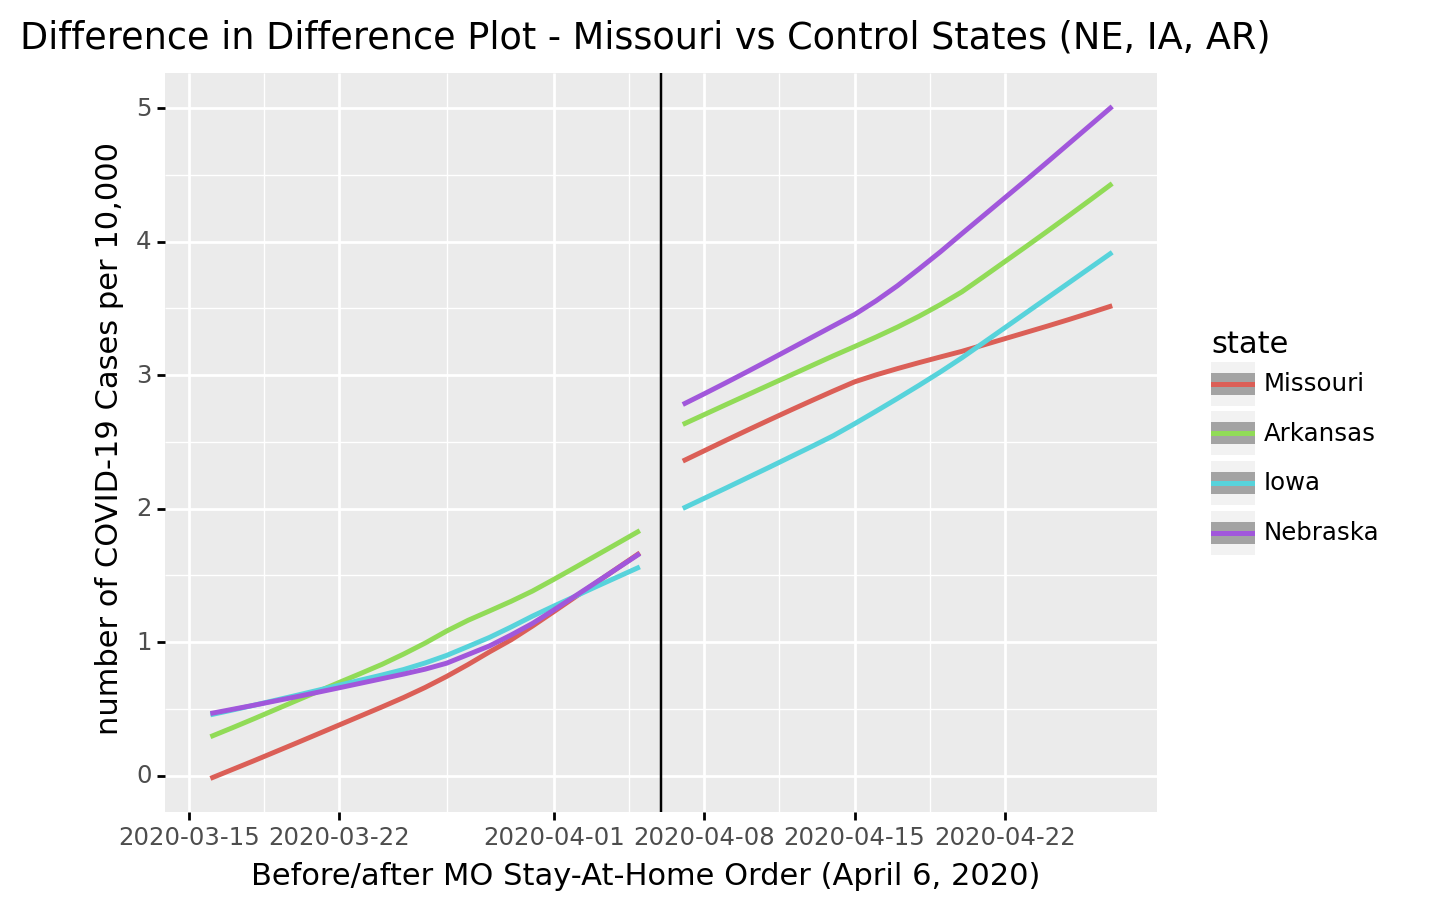

<ggplot: (8761808431598)>

<IPython.core.display.Javascript object>

In [19]:
# diff-in-diff plot - MO vs control States
(ggplot() +
    geom_smooth(merged_MO[merged_MO['date'] < '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='state'), method='lowess') + 
    geom_smooth(merged_MO[merged_MO['date'] > '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='state'), method='lowess') + 
        
    geom_smooth(merged_control[merged_control['date'] < '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='state'), method='lowess') + 
    geom_smooth(merged_control[merged_control['date'] > '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='state'), method='lowess')
    + geom_vline(xintercept = '2020-04-06')
    + xlab('Before/after MO Stay-At-Home Order (April 6, 2020)')
    + ylab(str("number of COVID-19 Cases per 10,000"))
    + labs(title=str("Difference in Difference Plot - Missouri vs Control States (NE, IA, AR)")))

In [20]:
# create indicator variable for treatment and control state
merged_MO['State'] = "Missouri"
merged_control['State'] = "Control States"

<IPython.core.display.Javascript object>

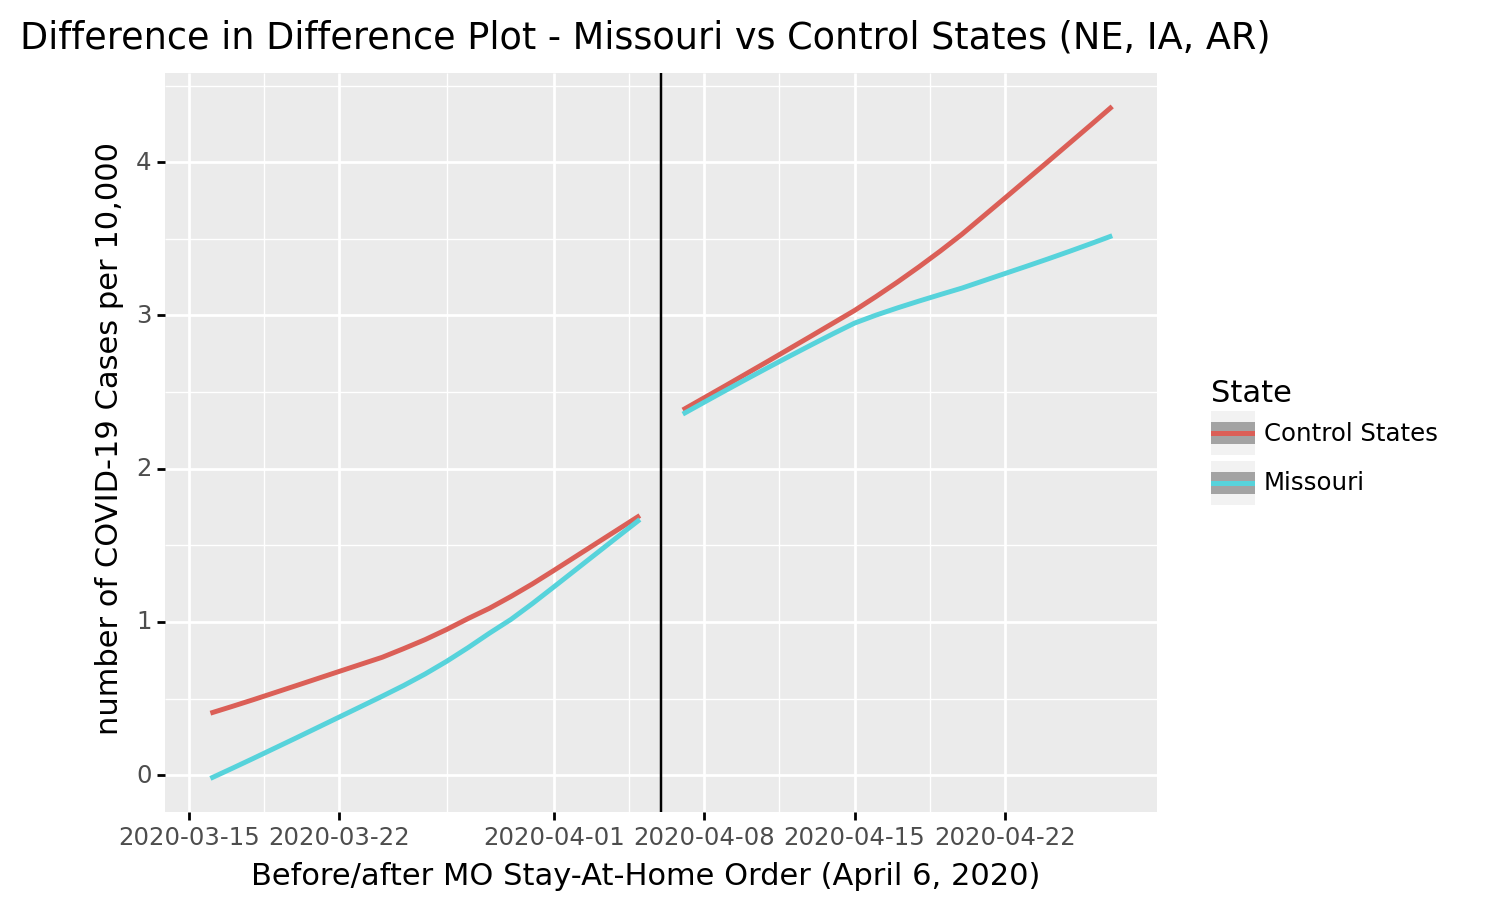

<ggplot: (8761809452963)>

<IPython.core.display.Javascript object>

In [21]:
# diff-in-diff plot - MO vs control counties
(ggplot() +
    geom_smooth(merged_control[merged_control['date'] < '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='State'), method='lowess') + 
    geom_smooth(merged_control[merged_control['date'] > '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='State'), method='lowess') +
    geom_smooth(merged_MO[merged_MO['date'] < '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='State'), method='lowess') + 
    geom_smooth(merged_MO[merged_MO['date'] > '2020-04-06'], 
                aes(x='date', y='cases_standardized', color='State'), method='lowess') 
    + geom_vline(xintercept = '2020-04-06')
    + xlab('Before/after MO Stay-At-Home Order (April 6, 2020)')
    + ylab(str("number of COVID-19 Cases per 10,000"))
    + labs(title=str("Difference in Difference Plot - Missouri vs Control States (NE, IA, AR)")))